In [92]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

In [696]:
# Load the crop mapping dwr data 
cm = gp.read_file("../shape/Crop__Mapping_2014.shp")

# Load cv shapefile
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs

# load canals shapefile 
canals = gp.read_file("../shape/Canals_and_Aqueducts_local.shp")
canals = gp.sjoin(canals, cvsa, op = "within")

# Shapefiles
hu4 = gp.read_file("../shape/HU4_merged.shp")

# swp = gp.read_file("../shape/SWP_Canals.shp")
# swp = gp.sjoin(swp, ca, op = "intersects")

# Read stream reaches from c2vsim shapefile 
reaches = gp.read_file("../c2vsim/C2VSimFG_StreamReaches.shp").dropna()
reaches = reaches.to_crs({'init': 'epsg:4326'})

# read rivers
rivers = gp.read_file("../shape/MajorRivers.shp")
rivers = gp.sjoin(rivers, hu4, op = "intersects")

# # irrigated
# irrigated = gp.read_file("../shape/irrigated.shp")
# non_irrigated = gp.read_file("../shape/non_irrigated.shp")

# SSJT
s = gp.read_file("../Shape/1802_4.shp")
sj = gp.read_file("../Shape/1804_4.shp")
t = gp.read_file("../Shape/1803_4.shp")

# grace footprint
grace_sa = gp.read_file("../shape/argus_grace.shp")

casgem = gp.read_file("../shape/casgem_wells.shp")
casgem = gp.sjoin(casgem,cvsa, op ='within')

In [3]:
# Bar plot of of acreage by crop type in 2014
out = {}

for i in cm.DWR_Standa.unique():
    acreage = cm[cm.DWR_Standa == i]['Acres'].sum()
    out[i] = acreage*0.00404686 # acres to sq km

In [4]:
total = np.array(list(out.values())).sum()

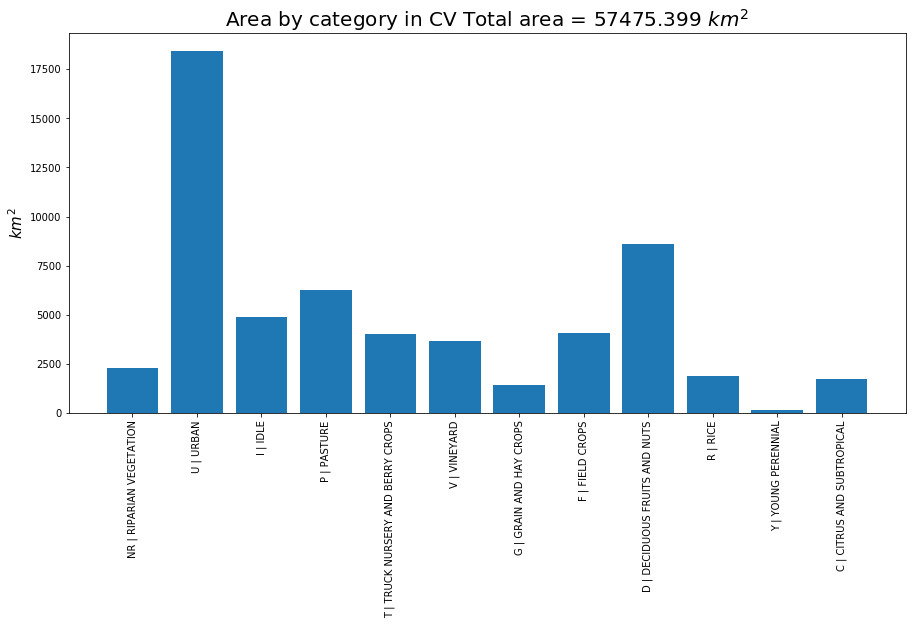

In [5]:
plt.figure(figsize=(15,7))
plt.bar(range(len(out)), out.values(), align='center')
plt.title("Area by category in CV Total area = {} $km^2$".format(str(round(total,3))), size = 20)
plt.xticks(range(len(out)), list(out.keys()),rotation='vertical')
plt.ylabel("$km^2$", size = 15)
plt.show()

In [6]:
irr_dfs = []

for i in list(cm.DWR_Standa.unique())[4:6]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[8:]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)

T | TRUCK NURSERY AND BERRY CROPS
V | VINEYARD
D | DECIDUOUS FRUITS AND NUTS
R | RICE
Y | YOUNG PERENNIAL
C | CITRUS AND SUBTROPICAL


In [7]:
non_irr_dfs = []

for i in list(cm.DWR_Standa.unique())[:1]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[6:8]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[2:4]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)

NR | RIPARIAN VEGETATION
G | GRAIN AND HAY CROPS
F | FIELD CROPS
I | IDLE
P | PASTURE


No handles with labels found to put in legend.


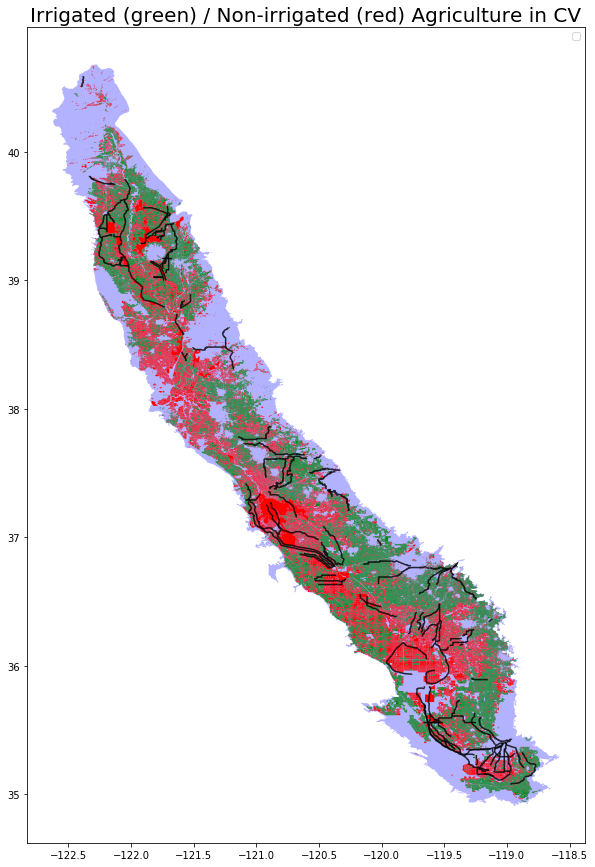

In [8]:
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(1, 1, 1)
cvsa.plot(ax=ax, color = "blue", alpha = 0.3)
canals.plot(ax = ax, color = "black", alpha = 0.8)

for i in range(len(irr_dfs)):
    irr_dfs[i].plot(ax=ax, color = "green", label = "irrigated")
    
for i in range(len(non_irr_dfs)):
    non_irr_dfs[i].plot(ax=ax, color = "red", label = "non irrigated")

ax.set_title("Irrigated (green) / Non-irrigated (red) Agriculture in CV", size = 20)

plt.legend()
plt.show()

In [9]:
# Now Convert the irrigated acreage to earth engine multipoly and query the ET data 

In [10]:
irrigated = pd.concat(irr_dfs)
non_irrigated = pd.concat(non_irr_dfs)

In [12]:
def gdf_to_ee_multipoly(gdf):

    lls = gdf.geometry.iloc[0]
    mps = [x for x in lls]
    multipoly = []

    for i in mps: 
        x,y = i.exterior.coords.xy
        coords = [list(zip(x,y))]
        multipoly.append(coords)

    return ee.Geometry.MultiPolygon(multipoly)


def get_area(gdf, fast = True):
    
    t = gdf.buffer(0.001).unary_union
    d  = gp.GeoDataFrame(geometry=gp.GeoSeries(t))
    if fast:
        d2  = gp.GeoDataFrame(geometry=gp.GeoSeries(d.simplify(0.001))) 
        area = gdf_to_ee_multipoly(d2)
    else:
        area = gdf_to_ee_multipoly(d)
        
    return area

In [13]:
area_irr = get_area(irrigated)

In [15]:
area_non_irr = get_area(non_irrigated)

In [16]:
data = {}

###################
##### ET data #####
###################

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
data['modis_aet'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "ET", 0.1]
data['modis_pet'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "PET", 0.1]

data['gldas_aet'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 86400*30 / 240] 
data['gldas_pet'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'PotEvap_tavg', 1 / 240] 

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas_pet'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
data['tc_aet'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "aet", 0.1]
data['tc_pet'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "pet", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET
data['gmet_etr'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "etr", 1]
data['gmet_eto'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "eto", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['fldas_aet'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "Evap_tavg", 86400*30]

###################
##### P data ######
###################

data['trmm']  =  [ee.ImageCollection('TRMM/3B43V7'), "precipitation", 720]
data['prism'] = [ee.ImageCollection("OREGONSTATE/PRISM/AN81m"), "ppt", 1]
data['chirps'] = [ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'), "precipitation", 1]
data['persia'] = [ee.ImageCollection("NOAA/PERSIANN-CDR"), "precipitation", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V3
data['dmet'] = [ee.ImageCollection('NASA/ORNL/DAYMET_V3'), "prcp", 1]

###################
##### SWE data #####
####################
data['swe'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "SWE_inst", 1 ]

####################
##### DS data ######
####################
data['grace'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_jpl", 1]

####################
##### R data #######
####################
data['r'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "ro", 1]
data['runoff'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "Qs_tavg", 86400*24]

#####################
##### SM data #######
#####################

data['sm'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "soil", 0.1]

data['sm1'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi00_10cm_tavg", 1]
data['sm2'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi10_40cm_tavg", 1]
data['sm3'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi40_100cm_tavg", 1]
data['sm4'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi100_200cm_tavg", 1]

In [37]:
def get_data(dataset, year, month, area):
    '''
    calculates the monthly sum a dataset in units of mm/time 
    '''

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
    # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
    scale = t2.projection().nominalScale()
    sumdict  = t2.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = area,
        scale = scale)
    
    result = sumdict.getInfo()[var]
    
    return result

def wrapper(dataset, area):
    
    '''
    Wrapper for `get_data` that takes a dataset and an area
    '''
    monthly = []

    for year in years:
        print(year)
        for month in months:
            r = get_data(dataset, year, month, area)
            monthly.append(r)
#             time.sleep(5)
    
    print("wrapper complete")
    return monthly

def gen_polys(geometry, dx=0.5, dy=0.5):
    
    '''
    Return ee.ImaceCollection of polygons used to submit full res queries
    '''
    
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    polys = []
    
    for lon in lonlist.getInfo():
        for lat in latlist.getInfo():
        
            def make_rect(lat, lon):
                lattemp = ee.Number(lat)
                lontemp = ee.Number(lon)
                uplattemp = lattemp.add(dy)
                lowlontemp = lontemp.add(dx)

                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],[lowlontemp, lattemp],[lowlontemp, uplattemp],[lontemp, uplattemp]]))
            
            poly = make_rect(lat,lon)
            polys.append(poly)
    
    return ee.FeatureCollection(ee.List(polys))

def chunk(dataset,area):
    polys = gen_polys(area)
    d = polys.getInfo()
    results = []
    for i in d['features']:
        aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
        t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(aoi).sum()
        t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)

        scale = t2.projection().nominalScale()
        sumdict  = t2.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = aoi,
            scale = scale)

        result = sumdict.getInfo()[var]
        results.append(result)
        print('poly complete')
        
    return results


def calc_monthly_sum(dataset, years, months, area):
    
    '''
    Calculates monthly sum for hourly data. works for GLDAS / NLDAS 
    '''
    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
            
    period_start = datetime.datetime(years[0], 1, 1)
    start_date = period_start.strftime("%Y-%m-%d")
    period_end = datetime.datetime(years[-1]+1, 1, 1)
    dt_idx = pd.date_range(period_start,period_end, freq='M')
    
    sums = []
    seq = ee.List.sequence(0, len(dt_idx))
    
    for i in seq.getInfo():
        start = ee.Date(start_date).advance(i, 'month')
        end = start.advance(1, 'month');
        im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', start.millis())
        ic = im.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
        scale = ic.projection().nominalScale()
        
        sumdict  = ic.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
        total = sumdict.getInfo()[var]
        sums.append(total)
        print(total)

    print("wrapper complete ")
    
    return sums


In [18]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [19]:
# Fetch AET in non-irrigated
fldas_aet = wrapper(data['fldas_aet'], area_non_irr)
modis_aet = wrapper(data['modis_aet'], area_non_irr)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


EEException: Earth Engine capacity exceeded.

In [41]:
tc_aet = wrapper(data['tc_aet'], area_non_irr)
gldas_aet = calc_monthly_sum(data['gldas_aet'], years, months, area_non_irr)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
0.29042525027133087
0.4615315512156677
1.1006665379532252
1.2821448773122686
1.4282462082270853
0.7909856419026978
0.4368506802056403
0.2170245197305961
0.13829078051672097
0.12690156131361335
0.2393490746611502
0.20662494606987206
0.3239619244085437
0.5702343769932803
1.063021292882509
1.207732654381884
1.1413688715876524
0.8080404285534469
0.41309379294635323
0.19556834926774655
0.09446326741861723
0.045447416246572545
0.3010343786971537
0.32721650631806015
0.4167230228515424
0.619745058448878
1.214724769742498
1.2220633895285684
1.5685307987919865
1.109227700059873
0.6461094339011985
0.4234171741651499
0.18559413227828558
0.08293511210481874
0.14837551223707507
0.2485001746287654
0.3318214554273778
0.4882611877248113
1.3644516758467458
1.3916096393458919
0.9745010944494382
0.5966498119306263
0.33257193795773904
0.17829635827852863
0.10247037250301542
0.21811935860826748
0.35204

In [420]:
# PET in non-irrigated (no gldas/nldas)
gmet_pet_non_irr = wrapper(data['gmet_eto'], area_non_irr)
gmet_pet2_non_irr = wrapper(data['gmet_etr'], area_non_irr)
modis_pet_non_irr = wrapper(data['modis_pet'], area_non_irr)
gldas_pet_non_irr = calc_monthly_sum(data['gldas_pet'], years, months, area_non_irr)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
0.886045279164488
1.0289193849420155
2.3829980182499413
3.2900425510312354
6.394797024558456
6.810841523063718
6.307366892492842
6.283150575712703
4.9259495246641425
3.8109799687660777
1.3145343248450183
0.6087762872850763
0.921727245550318
1.4920442073470224
2.588962542904803
3.6946590567945288
5.3539948634241625
6.880349384377771
7.107485300533918
6.395572875429313
5.268941878799916
3.674440132838581
1.8686942402472027
0.8917433170378115
1.1767946233681679
1.6118010943902865
2.851307974908775
2.8454753532248604
5.153073207884512
6.551011118536598
7.2954990062092095
6.302170236134442
5.383612309864264
4.136224449610822
1.5348273460863715
0.7607875472072894
0.90606033598

In [421]:
tc_pet_non_irr = wrapper(data['tc_pet'], area_non_irr)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [419]:
eto_g = wrapper(data['gmet_eto'], area_irr)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [23]:
# Fetch PET data in irrigated
eto_g = wrapper(data['gmet_eto'], area_irr)
etr_g = wrapper(data['gmet_etr'], area_irr)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [27]:
modis_pet = wrapper(data['modis_pet'], area_irr)
gldas_pet = calc_monthly_sum(data['gldas_pet'], years, months, area_irr)
# nldas_pet = calc_monthly_sum(data['nldas_pet'], years, months, area_irr)
# tc_pet = wrapper(data['tc_pet'], area_irr)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
wrapper complete 


KeyboardInterrupt: 

In [40]:
tc_pet = wrapper(data['tc_pet'], area_irr)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [549]:
# Make the objects into a dict 
d_aet_irr = {"fldas_aet": fldas_aet,  "gldas_aet":gldas_aet[:-1], "modis_aet":modis_aet, "tc_aet": tc_aet}
d_pet_irr = {"nldas_etr": nldas_pet[:-1], "gldas_etr": gldas_pet[:-1], "gmet_eto": eto_g, "gmet_etr": etr_g, "modis_pet": modis_pet, "tc_pet":tc_pet}
d_pet_total = {"gmet_eto_sum": [a + b for a, b in zip(eto_g, gmet_pet_non_irr)],
               "gmet_etr_sum": [a + b for a, b in zip(etr_g ,gmet_pet2_non_irr)],
               "modis_pet_sum": [a + b for a, b in zip(modis_pet,modis_pet_non_irr, )],
               "tc_pet_sum": [a + b for a, b in zip(tc_pet,tc_pet_non_irr)],
              }



In [538]:
# # List of all the values which are the timeseries for each var
# alldata = []

# alldat = [item for sublist in [d_aet_irr.values(), d_pet_irr.values(), d_pet_total.values()] for item in sublist]

# # Make the df
# alldata = pd.DataFrame(alldat).T
# alldata.index = dt_idx
# col_headers = [item for sublist in [d_aet_irr.keys(), d_pet_irr.keys(),d_pet_total.keys()] for item in sublist]
# alldata.columns = col_headers

In [669]:
df1 = pd.read_csv("../data/RS_DAT_FIN_monthly_2001_2018.csv", parse_dates = True, infer_datetime_format = True)
df2 = pd.read_csv("../data/RS_DAT_FIN_monthly_2001_2018_CVWshed.csv", parse_dates = True, infer_datetime_format = True)

def col_to_dt(df):
    t = df.copy()
    t['dt'] = pd.to_datetime(df[df.columns[0]])
    t = t.set_index(pd.to_datetime(t[t.columns[0]]))
    t.drop([t.columns[0], "dt"],axis = 1, inplace = True)
    
    return t

cv = col_to_dt(df1)
cvw = col_to_dt(df2)

In [670]:
# Apply crop coefficients to Et0 data (CV only)

df3 = pd.read_csv("../data/et_kc.csv")
etdf = col_to_dt(df3)

# Select the first year of scaling factors and apply this to the first 7 years of data
repeat_arr = etdf.et_multiplier[0:12]

# Merge with df
cvet = pd.merge(cv, etdf,how = "outer", left_index = True, right_index = True)
cvet.drop(cvet.tail(12).index,inplace=True)

# Make 7 concats of the yearly dataframe, fill the nans in the cvdf with that
temp = pd.DataFrame(repeat_arr)
temp = pd.concat([temp]*7, ignore_index=True)
cvet.et_multiplier[cvet.et_multiplier.isna()] = temp[temp.columns[0]].values

cv["et_multiplier"] = cvet.et_multiplier

# Subtract the CV ET vals from the cv watershed Et vals to isolate the non-CV
aet_cols = ['fldas_aet', 'gldas_aet', 'modis_aet', "tc_aet"]
for i in aet_cols:
    cvw[i] = cvw[i] - cv[i]
    
pet_cols = ['nldas_etr', 'gldas_etr', 'modis_pet', "tc_pet", "gmet_eto", "gmet_etr"]
for i in pet_cols:
    cvw[i] = cvw[i] - cv[i]


In [671]:
# For the ET dicts: 

# Make a dataframe from everything
et_data = [item for sublist in [d_aet_irr.values(), d_pet_irr.values(), d_pet_total.values()] for item in sublist]
et_data = pd.DataFrame(et_data).T
et_data.index = dt_idx
col_headers = [item for sublist in [d_aet_irr.keys(), d_pet_irr.keys(), d_pet_total.keys()] for item in sublist]
et_data.columns = col_headers

# multiply PETs by the crop coefficient df
et_data[list(d_pet_irr.keys())] = et_data[list(d_pet_irr.keys())].multiply(cvet["et_multiplier"], axis="index")
et_data[list(d_pet_total.keys())] = et_data[list(d_pet_total.keys())].multiply(cvet["et_multiplier"], axis="index")

In [672]:
# Join the AET / PET cols from et_data df to the CV df, amd join PET total col to the CVW df.

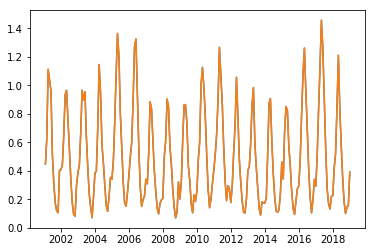

In [673]:
plt.plot(t.fldas_aet)
plt.plot(et_data.fldas_aet)

In [674]:
df = et_data.combine_first(cv)
# cvwdf = et_data.combine_first(cvw)

In [675]:
# df = pd.merge(cv, et_data, left_index = True, right_index = True)
# cvwdf = pd.merge(cvw, et_data, left_index = True, right_index = True)

In [676]:
# # # Drop the old et columns from cv 

# drop_cols = [0,1,2,3,4,5,6,7,8]
# cv.drop(cv.columns[drop_cols],axis=1,inplace=True)
# # cvw.drop(cvw.columns[drop_cols],axis=1,inplace=True)

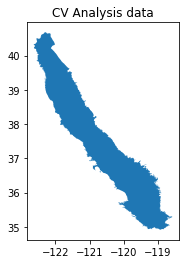

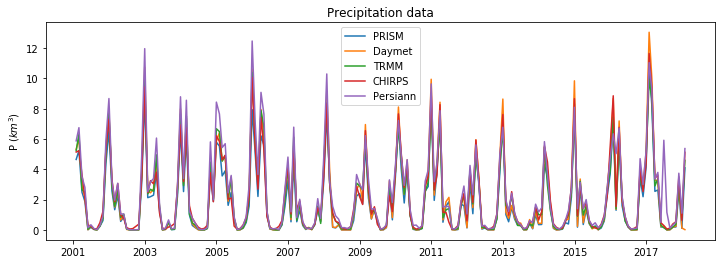

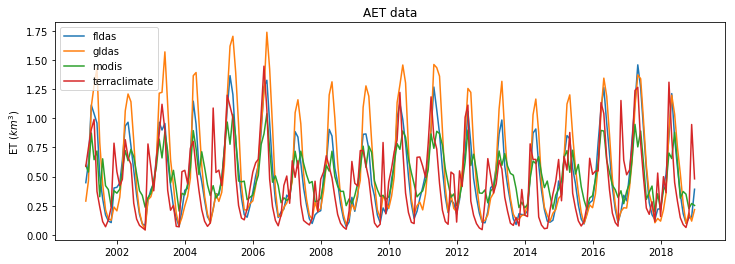

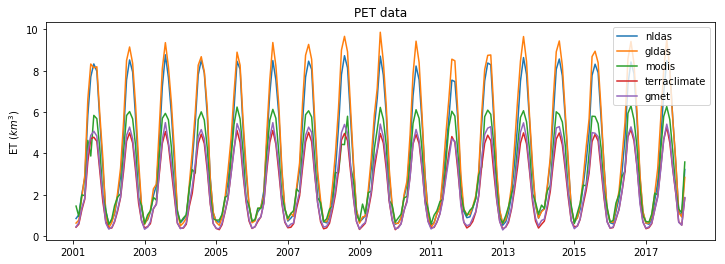

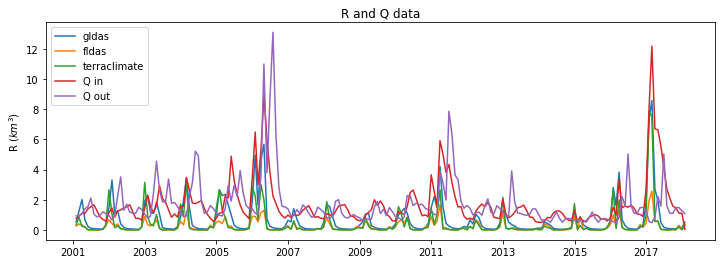

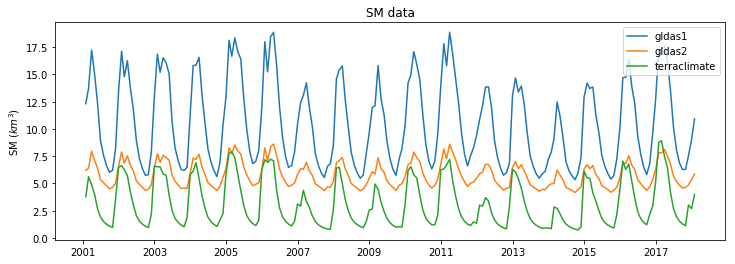

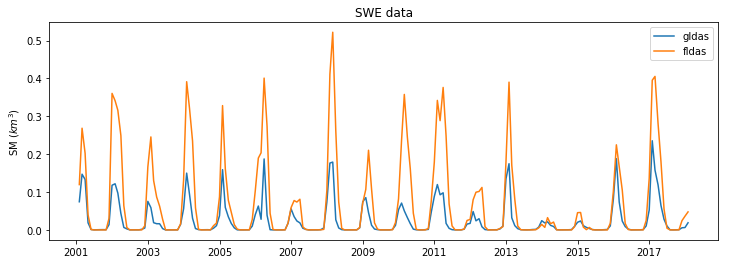

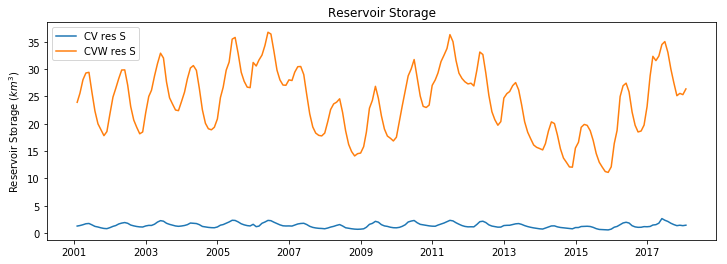

In [910]:
# Plot everything for CV 

cvsa.plot()
plt.title("CV Analysis data")

plt.figure(figsize = (12,4))
plt.title("Precipitation data")
plt.plot(df['p_prism'], label = "PRISM")
plt.plot(df['p_daymet'], label = "Daymet")
plt.plot(df['p_trmm'], label = "TRMM")
plt.plot(df['p_chirps'], label = 'CHIRPS')
plt.plot(df['p_persiann'], label = "Persiann")
plt.ylabel("P ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("AET data")
plt.plot(df.fldas_aet, label = "fldas")
plt.plot(df.gldas_aet, label = 'gldas')
plt.plot(df.modis_aet, label = 'modis')
plt.plot(df.tc_aet, label = "terraclimate")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("PET data")
plt.plot(df.nldas_etr, label = "nldas")
plt.plot(df.gldas_etr, label = 'gldas')
plt.plot(df.modis_pet, label = 'modis')
plt.plot(df.tc_pet, label = "terraclimate")
plt.plot(df.gmet_eto, label = "gmet")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("R and Q data")
plt.plot(df.gldas, label = "gldas")
plt.plot(df.fldas_r, label = 'fldas')
plt.plot(df.tc_r, label = 'terraclimate')
plt.plot(df.q_in, label =  "Q in")
plt.plot(df.q_out, label =  "Q out")
plt.ylabel("R ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("SM data")
plt.plot(df.gldas_sm, label = "gldas1")
plt.plot(df.gldas_m, label = 'gldas2')
plt.plot(df.tc_sm, label = "terraclimate")
plt.ylabel("SM ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("SWE data")
plt.plot(df.gldas_swe, label = "gldas")
plt.plot(df.fldas_swe, label = 'fldas')
# plt.plot(df.dmet_swe, label = "terraclimate")
plt.ylabel("SM ($km^3$)")
plt.legend()
plt.show()

plt.figure(figsize = (12,4))
plt.title("Reservoir Storage")
plt.plot(df.res_s, label = "CV res S")
plt.plot(cvw.res_s, label = "CVW res S")
plt.ylabel("Reservoir Storage ($km^3$)")
plt.legend()
plt.show()


In [678]:
# calculate means

df["aet_mean"] = np.mean([df['fldas_aet'], df['gldas_aet'],df['modis_aet'],df['tc_aet']],axis = 0)
df["pet_mean"] = np.mean([df['modis_pet'],df['tc_pet'],df['gmet_eto'],df['gmet_etr']],axis = 0)
df['et_mean'] = np.mean([df['pet_mean'], df['aet_mean']], axis = 0)
df["p_mean"] = np.mean([df['p_prism'], df['p_chirps'],df['p_persiann'],df['p_trmm'],df['p_daymet']],axis = 0)
df['sm_mean'] = np.mean([df['gldas_sm'], df['tc_sm'], df["gldas_m"]],axis = 0)
df['r_mean'] = np.mean([df['gldas'], df['fldas_r'], df["tc_r"], df['q_in']],axis = 0)
df['r_eff'] = np.mean([cvwdf['gldas'], cvwdf['fldas_r'], cvwdf["tc_r"]],axis = 0) - np.mean([df['gldas'], df['fldas_r'], df["tc_r"], df['q_in']],axis = 0)
df['swe_mean'] =  np.mean([df['fldas_swe'],df['gldas_swe']], axis = 0)
df['et_eff'] = np.sum([df['pet_mean'], df['aet_mean']],axis = 0)


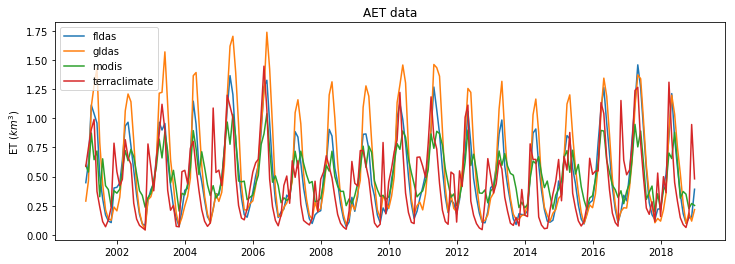

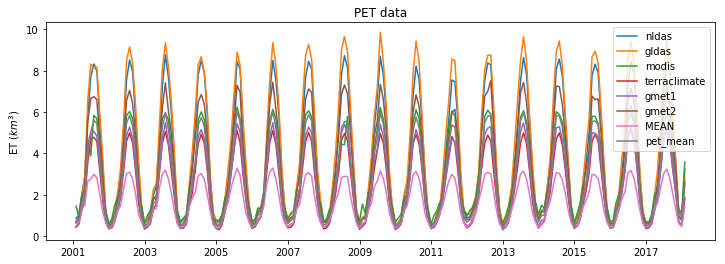

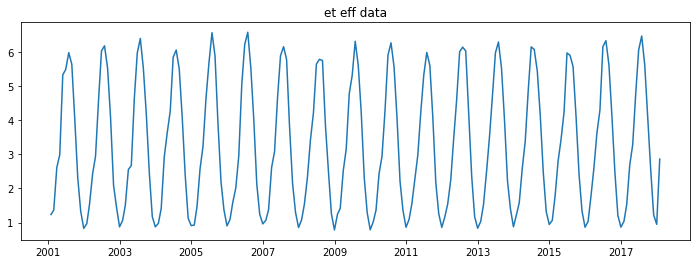

In [679]:
plt.figure(figsize = (12,4))
plt.title("AET data")
plt.plot(df.fldas_aet, label = "fldas")
plt.plot(df.gldas_aet, label = 'gldas')
plt.plot(df.modis_aet, label = 'modis')
plt.plot(df.tc_aet, label = "terraclimate")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("PET data")
plt.plot(df.nldas_etr, label = "nldas")
plt.plot(df.gldas_etr, label = 'gldas')
plt.plot(df.modis_pet, label = 'modis')
plt.plot(df.tc_pet, label = "terraclimate")
plt.plot(df.gmet_eto, label = "gmet1")
plt.plot(df.gmet_etr, label = "gmet2")
plt.plot(df.et_mean, label = "MEAN")

plt.plot(df.pet_mean)
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("et eff data")
plt.plot(df.et_eff, label = "effective et")

In [680]:
# Calculate ET for the CV watershed as ET CV + ET CV watershed

In [681]:
for i in list(d_aet_irr.keys()):
    cvwdf[i] = cvwdf[i] + df[i]
    
for i in list(d_pet_irr.keys()):
    cvwdf[i] = cvwdf[i] + df[i]
#     cvwdf[i+"_sum"] = cvwdf[i] + df[i+"_sum"]

for i in list(d_pet_total.keys()):
    try:
        strid = i[:-4]
        cvwdf[strid] = cvwdf[strid] + df[strid]
    except:
        continue


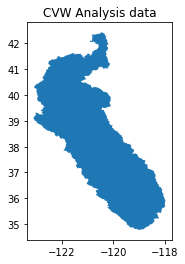

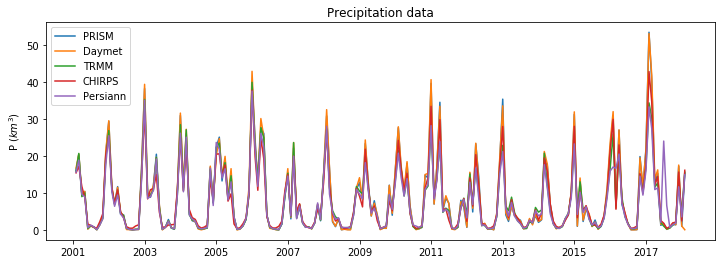

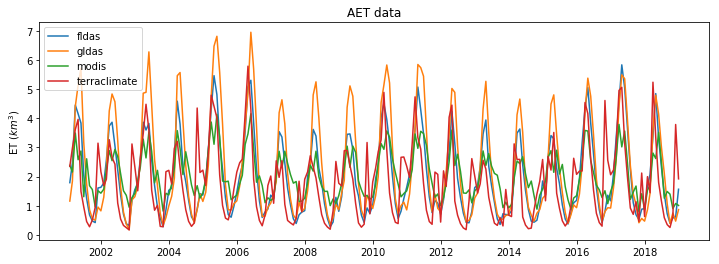

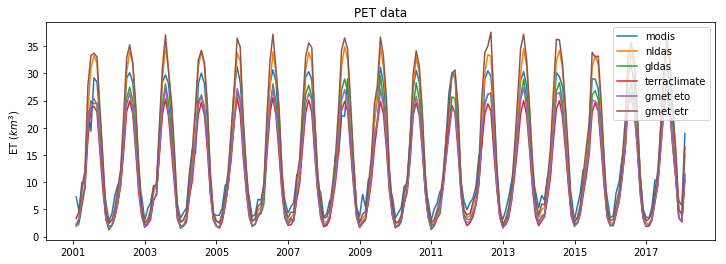

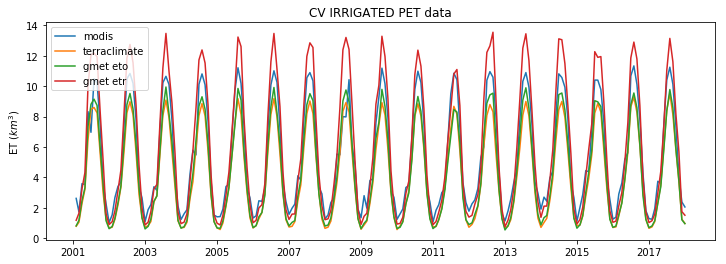

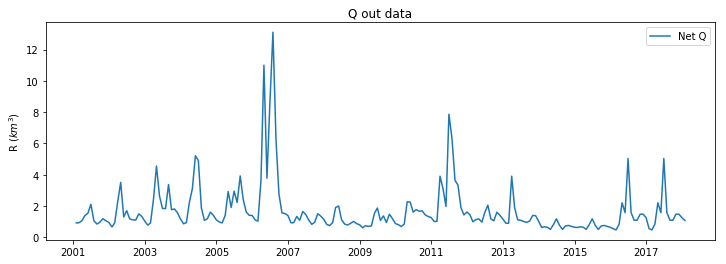

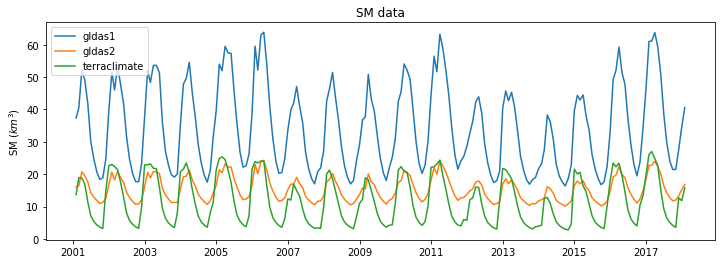

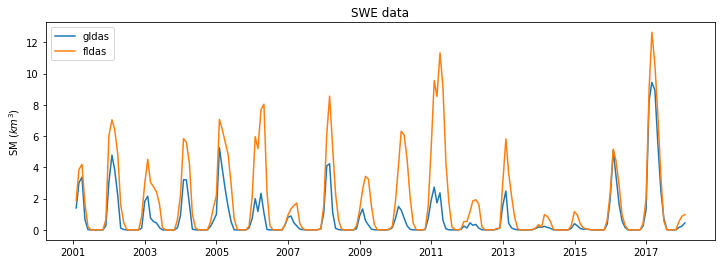

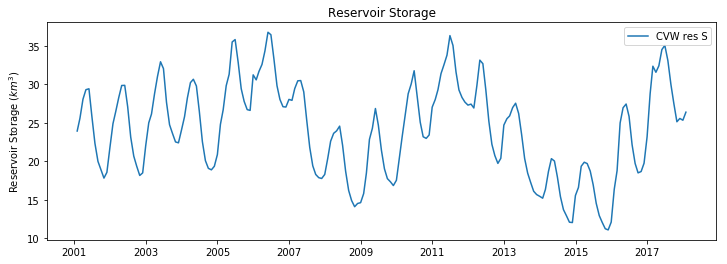

In [710]:
# Plot everything for CVW

hu4.plot()
plt.title("CVW Analysis data")

plt.figure(figsize = (12,4))
plt.title("Precipitation data")
plt.plot(cvw['p_prism'], label = "PRISM")
plt.plot(cvw['p_daymet'], label = "Daymet")
plt.plot(cvw['p_trmm'], label = "TRMM")
plt.plot(cvw['p_chirps'], label = 'CHIRPS')
plt.plot(cvw['p_persiann'], label = "Persiann")
plt.ylabel("P ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("AET data")
plt.plot(cvw.fldas_aet, label = "fldas")
plt.plot(cvw.gldas_aet, label = 'gldas')
plt.plot(cvw.modis_aet, label = 'modis')
plt.plot(cvw.tc_aet, label = "terraclimate")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("PET data")
plt.plot(cvw.modis_pet, label = 'modis')
plt.plot(cvw.nldas_etr, label = 'nldas')
plt.plot(cvw.gldas_etr, label = 'gldas')
plt.plot(cvw.tc_pet, label = "terraclimate")
plt.plot(cvw.gmet_eto, label = "gmet eto")
plt.plot(cvw.gmet_etr, label = "gmet etr")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("CV IRRIGATED PET data")
plt.plot(cvw.modis_pet_sum, label = 'modis')
plt.plot(cvw.tc_pet_sum, label = "terraclimate")
plt.plot(cvw.gmet_eto_sum, label = "gmet eto")
plt.plot(cvw.gmet_etr_sum, label = "gmet etr")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("Q out data")
plt.plot(cvw.q_out, label = "Net Q")
plt.ylabel("R ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("SM data")
plt.plot(cvw.gldas_sm, label = "gldas1")
plt.plot(cvw.gldas_m, label = 'gldas2')
plt.plot(cvw.tc_sm, label = "terraclimate")
plt.ylabel("SM ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("SWE data")
plt.plot(cvw.gldas_swe, label = "gldas")
plt.plot(cvw.fldas_swe, label = 'fldas')
# plt.plot(df.dmet_swe, label = "terraclimate")
plt.ylabel("SM ($km^3$)")
plt.legend()
plt.show()

plt.figure(figsize = (12,4))
plt.title("Reservoir Storage")
plt.plot(cvw.res_s, label = "CVW res S")
plt.ylabel("Reservoir Storage ($km^3$)")
plt.legend()
plt.show()


In [721]:
# Calc means for the CV Watershed 
def calc_means(df):
    df["aet_mean"] = np.mean([df['fldas_aet'], df['gldas_aet'],df['modis_aet'],df['tc_aet']],axis = 0)
    df["pet_mean"] = np.mean([df['modis_pet'],df['tc_pet'],df['gmet_eto'], df['gmet_etr']],axis = 0)
    df['et_mean'] = np.mean([df['pet_mean'], df['aet_mean']], axis = 0)
    df["p_mean"] = np.mean([df['p_prism'], df['p_chirps'],df['p_persiann'],df['p_trmm'],df['p_daymet']],axis = 0)
    df['sm_mean'] = np.mean([df['gldas_sm'], df['tc_sm'], df["gldas_m"]],axis = 0)
    df['r_mean'] = np.mean([df['gldas'], df['fldas_r'], df["tc_r"], df['q_in']],axis = 0)
    df['r_eff'] = np.mean([cvwdf['gldas'], cvwdf['fldas_r'], cvwdf["tc_r"], cvwdf['q_in']],axis = 0) - np.mean([df['gldas'], cv['fldas_r'], cv["tc_r"], cv['q_in']],axis = 0)
    df['swe_mean'] =  np.mean([df['fldas_swe'],df['gldas_swe']], axis = 0)
    df['pet_irr_mean'] = np.mean([df['gmet_eto_sum'],df['modis_pet_sum'],df['tc_pet_sum']],axis = 0) # Drop the gmet etr 
    df['et_eff'] = np.sum([df['pet_irr_mean'], df['aet_mean']],axis = 0)
    return df

cvwdf = calc_means(cvwdf)

In [722]:
# Grace data

grace = pd.read_csv("../data/grace_argus.csv")

# Initialize the datetime columns
grace['dt'] = pd.to_datetime(grace[grace.columns[0]])
grace = grace.set_index(pd.to_datetime(grace[grace.columns[0]]))
grace.drop(["dt"],axis = 1, inplace = True)

# Subtract reservoir storage, soil moisture, SWE from grace 
grace['adj'] = grace.grace_mean[1:] - cvw.sm_mean.diff()[1:] - cvw.res_s.diff()[1:] - cvw.swe_mean.diff()[1:]

# Wells data (processed by zihan using Faunt 2009 SY values )
wells = pd.read_csv("../data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)

wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)

wells['ds_km3'] = wells[wells.columns[-1]] * 50000 * 1e-5

# c2vsim storage data 
c2vs = pd.read_csv("../data/all_data_cv.csv")
c2vs.ds = c2vs.s.diff()
df['c2vsim'] = c2vs.s.diff().values[-len(df):]

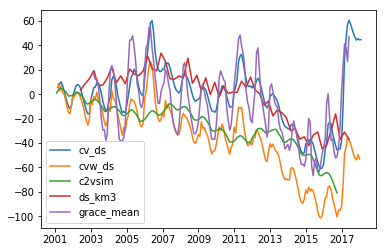

In [733]:
df["cv_ds"] = df.p_mean - (df.pet_mean + df.aet_mean) - df.q_out + df.q_in + df.r_eff - df.sm_mean.diff() - df.res_s.diff() - df.gldas_swe.diff()
cvwdf["cvw_ds"] = cvwdf.p_mean - (cvwdf.et_eff) - cvwdf.q_out  - cvwdf.sm_mean.diff() - cvwdf.res_s.diff() - cvwdf.swe_mean.diff()

plt.plot(np.cumsum(df.cv_ds))
plt.plot(np.cumsum(cvwdf.cvw_ds))
plt.plot(np.cumsum(df.c2vsim))
plt.plot(wells.ds_km3)
plt.plot(grace.grace_mean)
plt.legend()

plt.show()

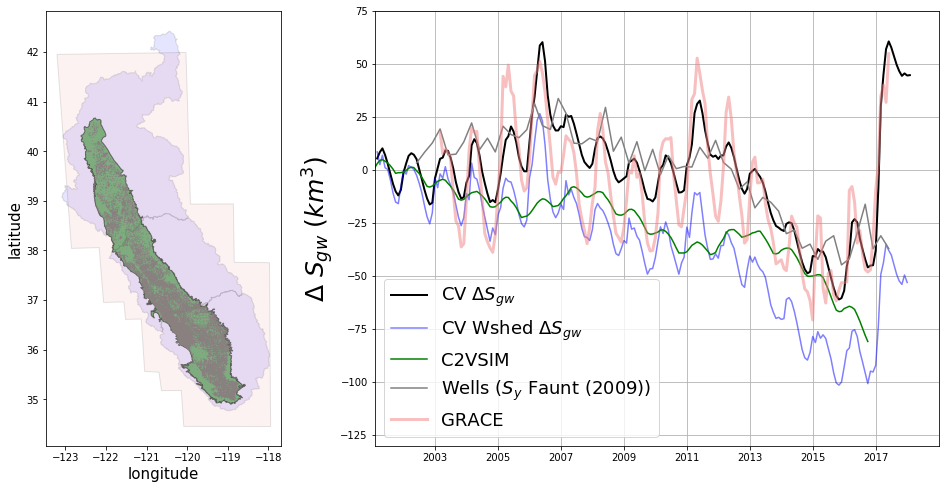

In [918]:
plt.figure(figsize=(16, 8))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
ax = plt.subplot(G[:, 0])

# Plot the huc4s
s.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
sj.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
t.plot(ax = ax, color = 'blue', alpha = 0.1,  edgecolor = "black")

# Rivers, CV, canals, CA, irrigated, non irrigated
# rivers.plot(ax = ax, color = "blue", label = "major rivers")
cvsa.plot(ax = ax, color = "green", edgecolor = "black", alpha = 0.5, label = "central valley")
# canals.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5, label = "CVP canals / aqueducts")
casgem.plot(ax = ax, marker = ".", markersize = 0.1, color = 'gray')
# irrigated.plot(ax = ax, color = "green", alpha = 0.7, label = "irrigated")
# non_irrigated.plot(ax = ax, color = "yellow", alpha = 0.7, label = 'non-irrigated')
grace_sa.plot(ax = ax, color = "lightcoral", alpha = 0.1, edgecolor = 'black')

plt.ylabel('latitude', size = 15)
plt.xlabel('longitude', size = 15)

# Plot the timeseries
axes_4 = plt.subplot(G[0:2, 1:])
axes_4.plot(df.index, np.cumsum(df.cv_ds), color="black", linewidth = 2, label = "CV $\Delta S_{gw}$")
axes_4.plot(df.index, np.cumsum(cvwdf.cvw_ds), color="blue",alpha = 0.5, label = "CV Wshed $\Delta S_{gw}$")
axes_4.plot(df.index, np.cumsum(df.c2vsim), color="green", label = "C2VSIM")
# axes_4.plot(df2.index, np.cumsum(df2.ds), color="red", label = "CVW $\Delta S_{gw}$ ")
axes_4.plot(wells.index, wells.ds_km3, color="gray", label = "Wells ($S_y$ Faunt (2009))")
axes_4.plot(grace.index, grace.adj, color="lightcoral", linewidth = 3, alpha = .5, label = "GRACE")

axes_4.set_ylim(-130,75)
axes_4.set_xlim(df.index[0],df.index[-1])

axes_4.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25) 
axes_4.legend(loc = "lower left",  prop={'size':18})

plt.grid(True)
G.update(wspace=0.4, hspace=0.3) # set the spacing between axes. 

# plt.tight_layout()
plt.show()

In [720]:
df.to_csv("../data/WRR_cv_balance.csv")
cvwdf.to_csv("../data/WRR_cvw_balance.csv")

In [734]:
# Do triple collocation on grace, wells, rs model

def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) /
            np.std(src)) * np.std(ref) + np.mean(ref)

In [741]:
x = np.cumsum(df.cv_ds)
y = wells.ds_km3
z = np.cumsum(df.c2vsim)

y_scaled = scale_to_ref(y,x)
z_scaled = scale_to_ref(z,x)

e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)
print (e_x,e_y,e_z)

12.076161431339587 8.421606340416828 13.478664420815154


In [742]:
tc_dat = [np.cumsum(df.cv_ds), wells.ds_km3, np.cumsum(df.c2vsim), grace.adj]

In [754]:
from itertools import combinations

comb = combinations(tc_dat, 3) 

for i in comb:
    x = i[0]
    y = i[1]
    z = i[2]
    
    y_scaled = scale_to_ref(y,x)
    z_scaled = scale_to_ref(z,x)

    e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

    print(i[0].head(), i[1].head(), i[2].head())

2001-01-31          NaN
2001-02-28     5.443244
2001-03-31     8.446812
2001-04-30    10.210305
2001-05-31     7.103762
Name: cv_ds, dtype: float64 Date
2002-05-31     3.341500
2002-08-31     8.324651
2002-11-30    12.756168
2003-02-28    19.352305
2003-05-31     7.133276
Name: ds_km3, dtype: float64 2001-01-31    1.014146
2001-02-28    3.012392
2001-03-31    4.543201
2001-04-30    4.890189
2001-05-31    4.131687
Name: c2vsim, dtype: float64
2001-01-31          NaN
2001-02-28     5.443244
2001-03-31     8.446812
2001-04-30    10.210305
2001-05-31     7.103762
Name: cv_ds, dtype: float64 Date
2002-05-31     3.341500
2002-08-31     8.324651
2002-11-30    12.756168
2003-02-28    19.352305
2003-05-31     7.133276
Name: ds_km3, dtype: float64 Unnamed: 0
2003-01-31          NaN
2003-02-28    17.864675
2003-03-31     7.710363
2003-04-30     9.774222
2003-05-31     8.420153
Name: adj, dtype: float64
2001-01-31          NaN
2001-02-28     5.443244
2001-03-31     8.446812
2001-04-30    10.210305

In [826]:
combos=combinations([0,1,2,3], 3) 

out = {0:[], # rs
       1:[], # wells
       2:[], # c2vsim
       3:[]  # grace 
        }

# out = {}

for idx,i in enumerate(combos):
    x = tc_dat[i[0]]
    y = tc_dat[i[1]]
    z = tc_dat[i[2]]
    
    y_scaled = scale_to_ref(y,x)
    z_scaled = scale_to_ref(z,x)

    e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)
    
    errors = calc_tc_error(x, y_scaled, z_scaled)
    
    for idx,j in enumerate(i):
        out[j].append(errors[idx])
        
D = {k:np.array(v).mean() for k,v in out.items() }
maxs = {k:np.array(v).max() for k,v in out.items() }
mins = {k:np.array(v).min() for k,v in out.items() }

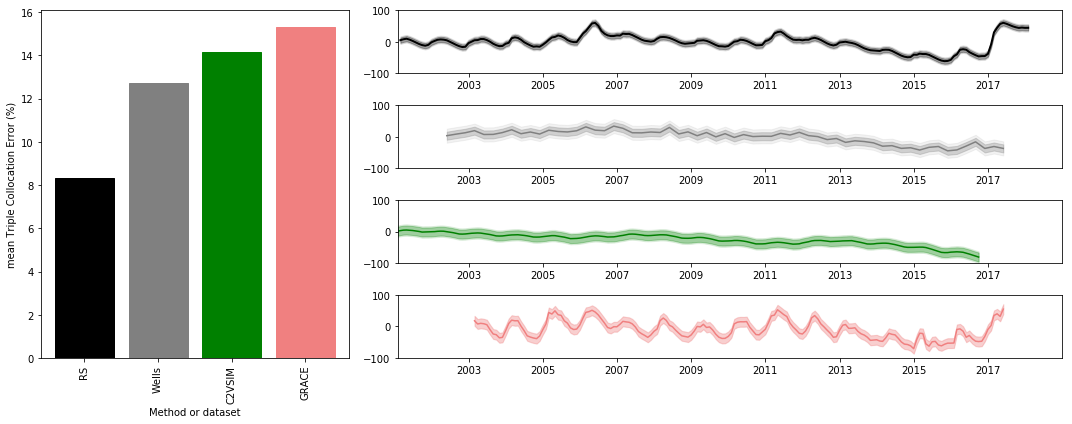

In [840]:
# Plot the TC bar chart and time series
plt.figure(figsize = (15,6))

G = gridspec.GridSpec(4, 3)

# Plot the basemaps
ax = plt.subplot(G[:, 0])

bars = plt.bar(range(len(D)), list(D.values()), align='center')
bars[0].set_color('black')
bars[1].set_color('gray')
bars[2].set_color('green')
bars[-1].set_color('lightcoral')
plt.xticks(range(len(D)), ["RS", "Wells", "C2VSIM", "GRACE"], rotation='vertical')
plt.ylabel("mean Triple Collocation Error (%)")
plt.xlabel("Method or dataset")

# ax2 = plt.subplot(G[:, 0])
axes_2 = plt.subplot(G[0:1, 1:])
axes_2.plot(df.index, np.cumsum(df.cv_ds), color="black", linewidth = 2, label = "CV $\Delta S_{gw}$")
axes_2.fill_between(df.index, np.cumsum(df.cv_ds)+D[0], np.cumsum(df.cv_ds)-D[0], color="black", alpha = 0.3, label = "CV $\Delta S_{gw}$")
axes_2.fill_between(df.index, np.cumsum(df.cv_ds)+maxs[0], np.cumsum(df.cv_ds)-maxs[0], color="black", alpha = 0.1, label = "CV $\Delta S_{gw}$")
axes_2.set_ylim([-100,100])
axes_2.set_xlim(df.index[0],df.index[-1])

axes_3 = plt.subplot(G[1:2, 1:])
axes_3.plot(wells.index,wells.ds_km3, color="gray", label = "wells")
axes_3.fill_between(wells.index, wells.ds_km3+D[1],wells.ds_km3-D[1], color="gray", alpha = 0.3, label = "CV $\Delta S_{gw}$")
axes_3.fill_between(wells.index, wells.ds_km3+maxs[1],wells.ds_km3-maxs[1], color="gray", alpha = 0.1, label = "CV $\Delta S_{gw}$")
axes_3.set_ylim([-100,100])
axes_3.set_xlim(df.index[0],df.index[-1])

axes_4 = plt.subplot(G[2:3, 1:])
axes_4.plot(df.index, np.cumsum(df.c2vsim), color="green", label = "C2VSIM")
axes_4.fill_between(df.index, np.cumsum(df.c2vsim)+D[2], np.cumsum(df.c2vsim)-D[2], color="green", alpha = 0.3, label = "CV $\Delta S_{gw}$")
axes_4.fill_between(df.index, np.cumsum(df.c2vsim)+maxs[2], np.cumsum(df.c2vsim)-maxs[2], color="green", alpha = 0.1, label = "CV $\Delta S_{gw}$")
axes_4.set_ylim([-100,100])
axes_4.set_xlim(df.index[0],df.index[-1])

axes_5 = plt.subplot(G[3:4, 1:])
axes_5.plot(grace.index, grace.adj, color="lightcoral", label = "GRACE")
axes_5.fill_between(grace.index, grace.adj+D[3],  grace.adj-D[3], color="lightcoral", alpha = 0.3, label = "CV $\Delta S_{gw}$")
axes_5.fill_between(grace.index, grace.adj+maxs[3],  grace.adj-maxs[3], color="lightcoral", alpha = 0.1, label = "CV $\Delta S_{gw}$")
axes_5.set_ylim([-100,100])
axes_5.set_xlim(df.index[0],df.index[-1])

plt.tight_layout()
plt.show()

In [980]:
# Merge all the DFS and create a mean error 

merged1 = pd.merge(df, wells, left_index=True, right_index=True, how = "outer")
merged2 = pd.merge(merged1, grace, left_index=True, right_index=True, how = "outer")

for idx,x in enumerate(["cv_ds",'ds_km3', "c2vsim",'adj']):
    merged2[x+"_max"] = merged2[x] + D[idx]
    merged2[x+"_min"] = merged2[x] - D[idx]
    
merged2['cs'] = np.cumsum(df.cv_ds)
merged2['ds_mean'] = np.nanmean(merged2[["cs",'ds_km3', "c2vsim",'adj']], axis = 1)
merged2['upper_bound'] = np.nanmean(merged2[["cs",'ds_km3_max', "c2vsim_max",'adj_max']], axis = 1)
merged2['lower_bound'] = np.nanmean(merged2[["cs",'ds_km3_min', "c2vsim_min",'adj_min']], axis = 1)

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


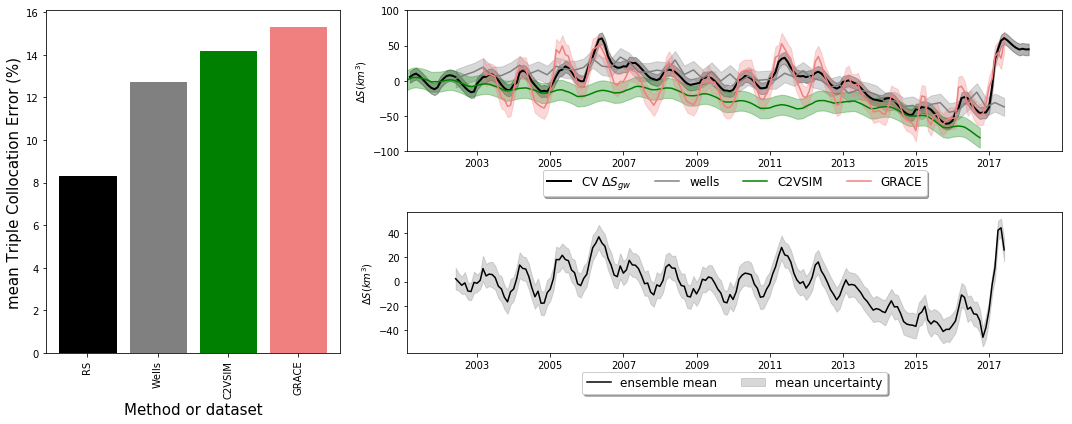

In [981]:
# Plot the TC bar chart and time series
plt.figure(figsize = (15,6))

G = gridspec.GridSpec(4, 3)

# Plot the basemaps
ax = plt.subplot(G[:, 0])

bars = plt.bar(range(len(D)), list(D.values()), align='center')
bars[0].set_color('black')
bars[1].set_color('gray')
bars[2].set_color('green')
bars[-1].set_color('lightcoral')
plt.xticks(range(len(D)), ["RS", "Wells", "C2VSIM", "GRACE"], rotation='vertical')
plt.ylabel("mean Triple Collocation Error (%)", size = 15)
plt.xlabel("Method or dataset", size = 15)

# ax2 = plt.subplot(G[:, 0])
axes_2 = plt.subplot(G[0:2, 1:])
axes_2.plot(df.index, np.cumsum(df.cv_ds), color="black", linewidth = 2, label = "CV $\Delta S_{gw}$")
axes_2.fill_between(df.index, np.cumsum(df.cv_ds)+D[0], np.cumsum(df.cv_ds)-D[0], color="black", alpha = 0.3)
# axes_2.fill_between(df.index, np.cumsum(df.cv_ds)+maxs[0], np.cumsum(df.cv_ds)-maxs[0], color="black", alpha = 0.1)

axes_2.plot(wells.index,wells.ds_km3, color="gray", label = "wells")
axes_2.fill_between(wells.index, wells.ds_km3+D[1],wells.ds_km3-D[1], color="gray", alpha = 0.3)
# axes_2.fill_between(wells.index, wells.ds_km3+maxs[1],wells.ds_km3-maxs[1], color="gray", alpha = 0.1)

axes_2.plot(df.index, np.cumsum(df.c2vsim), color="green", label = "C2VSIM")
axes_2.fill_between(df.index, np.cumsum(df.c2vsim)+D[2], np.cumsum(df.c2vsim)-D[2], color="green", alpha = 0.3)
# axes_2.fill_between(df.index, np.cumsum(df.c2vsim)+maxs[2], np.cumsum(df.c2vsim)-maxs[2], color="green", alpha = 0.1)

axes_2.plot(grace.index, grace.adj, color="lightcoral", label = "GRACE")
axes_2.fill_between(grace.index, grace.adj+D[3],  grace.adj-D[3], color="lightcoral", alpha = 0.3)
# axes_2.fill_between(grace.index, grace.adj+maxs[3],  grace.adj-maxs[3], color="lightcoral", alpha = 0.1)

axes_2.set_ylim([-100,100])
axes_2.set_xlim(df.index[0],df.index[-1])
axes_2.set_ylabel("$\Delta S (km^3)$")
axes_2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

axes_3 = plt.subplot(G[2:4, 1:])

axes_3.plot(merged2.ds_mean[16:-19], color = "black", label = 'ensemble mean')
axes_3.fill_between(merged2.index[16:-19], merged2.upper_bound[16:-19], merged2.lower_bound[16:-19] ,color = "gray", alpha = 0.3, label = "mean uncertainty")
axes_3.set_xlim(df.index[0],df.index[-1])
axes_3.set_ylabel("$\Delta S (km^3)$")
axes_3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

plt.tight_layout()
plt.show()